## Ablation of top-k Guided Generation. Study of "k" influence.

We analyze how the value of "k" affects the result using concept probing.

In [1]:
import pandas as pd

from frames.nlp.datasets import load_multilingual_question_dataset
from frames.representations import FrameUnembeddingRepresentation
from frames.utils.plotting import lineplot_and_save

In [ ]:
# parameters
MODEL_ID = "hugging-quants/Meta-Llama-3.1-70B-Instruct-AWQ-INT4"
N = 1 << 9
STEPS = 1 << 5
BATCH_SIZE = 1 << 5

GUIDES = [("female.n.01", "male.n.01"), ("black.n.01", "white.n.01")]

X = "token index"
Y = "total projection"
HUE = "guidance level"
HUE2 = "guidance"

TOPK_ABLATION_K = (3, 2, 1)

In [ ]:
fur = FrameUnembeddingRepresentation.from_model_id(MODEL_ID)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
dataset = load_multilingual_question_dataset(fur.data.languages).iloc[:N]
samples, langs = dataset.shape
print("Loaded dataset with", samples, "samples and", langs, "languages")

Loaded dataset with 512 samples and 8 languages


In [ ]:
def gen_guided_probe(inputs, guide, k):
    _, probe = fur.quick_generate_with_topk_guide(
        inputs,
        guide=guide,
        k=k,
        steps=STEPS,
        batch_size=BATCH_SIZE,
        min_lemmas_per_synset=3,
        max_token_count=3,
    )
    return pd.DataFrame(probe).melt(var_name=X, value_name=Y)

100%|██████████| 16/16 [03:59<00:00, 14.96s/it]


OSError: Cannot save file into a non-existent directory: 'resources'

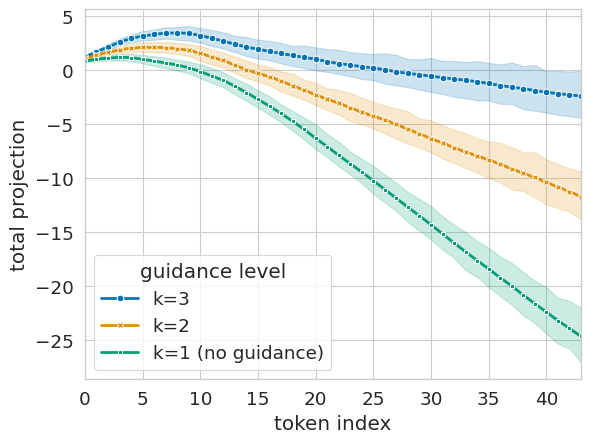

In [ ]:
inputs = dataset["English"].tolist()

df = pd.concat(
    [gen_guided_probe(inputs, guide, k).assign(**{HUE: f"{k=}", HUE2: f"{guide[0]} - {guide[1]}"}) for k in TOPK_ABLATION_K for guide in GUIDES]
)
df[HUE] = df[HUE].replace("k=1", "k=1 (no guidance)")

lineplot_and_save("06_guided_generation_top_k_ablation", df, x=X, y=Y, hue=HUE)

(0.0, 43.0)

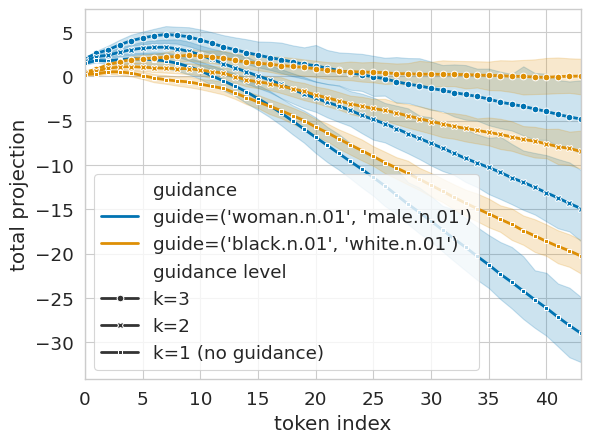

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(
    df,
    x=X,
    y=Y,
    hue=HUE2,
    style=HUE,
    markers=True,
    dashes=False,
    errorbar=("ci", 99),
    palette="colorblind",
    linewidth=2,
)
plt.xlim(0, df.groupby(HUE)[X].max().min())